In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns',200)
pd.set_option("display.max_info_rows", 800)
pd.set_option('display.max_info_columns',800)

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")
    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict


def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
    # Get predictions for training data
    y_train_pred = model.predict(X_train)
    # Call the helper function to obtain regression metrics for training data
    results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
    print()
    # Get predictions for test data
    y_test_pred = model.predict(X_test)
    # Call the helper function to obtain regression metrics for test data
    results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
    if output_dict == True:
        # Store results in a dataframe if ouput_frame is True
        results_dict = {'train':results_train,
                    'test': results_test}
        return results_dict

In [3]:
df= pd.read_csv('Data/pd_speech_features.csv')
df.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,...,tqwt_maxValue_dec_10,tqwt_maxValue_dec_11,tqwt_maxValue_dec_12,tqwt_maxValue_dec_13,tqwt_maxValue_dec_14,tqwt_maxValue_dec_15,tqwt_maxValue_dec_16,tqwt_maxValue_dec_17,tqwt_maxValue_dec_18,tqwt_maxValue_dec_19,tqwt_maxValue_dec_20,tqwt_maxValue_dec_21,tqwt_maxValue_dec_22,tqwt_maxValue_dec_23,tqwt_maxValue_dec_24,tqwt_maxValue_dec_25,tqwt_maxValue_dec_26,tqwt_maxValue_dec_27,tqwt_maxValue_dec_28,tqwt_maxValue_dec_29,tqwt_maxValue_dec_30,tqwt_maxValue_dec_31,tqwt_maxValue_dec_32,tqwt_maxValue_dec_33,tqwt_maxValue_dec_34,tqwt_maxValue_dec_35,tqwt_maxValue_dec_36,tqwt_skewnessValue_dec_1,tqwt_skewnessValue_dec_2,tqwt_skewnessValue_dec_3,tqwt_skewnessValue_dec_4,tqwt_skewnessValue_dec_5,tqwt_skewnessValue_dec_6,tqwt_skewnessValue_dec_7,tqwt_skewnessValue_dec_8,tqwt_skewnessValue_dec_9,tqwt_skewnessValue_dec_10,tqwt_skewnessValue_dec_11,tqwt_skewnessValue_dec_12,tqwt_skewnessValue_dec_13,tqwt_skewnessValue_dec_14,tqwt_skewnessValue_dec_15,tqwt_skewnessValue_dec_16,tqwt_skewnessValue_dec_17,tqwt_skewnessValue_dec_18,tqwt_skewnessValue_dec_19,tqwt_skewnessValue_dec_20,tqwt_skewnessValue_dec_21,tqwt_skewnessValue_dec_22,tqwt_skewnessValue_dec_23,tqwt_skewnessValue_dec_24,tqwt_skewnessValue_dec_25,tqwt_skewnessValue_dec_26,tqwt_skewnessValue_dec_27,tqwt_skewnessValue_dec_28,tqwt_skewnessValue_dec_29,tqwt_skewnessValue_dec_30,tqwt_skewnessValue_dec_31,tqwt_skewnessValue_dec_32,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883

In [4]:
# Prepare dataset for ML
df.dtypes.value_counts()

float64    749
int64        6
dtype: int64

In [5]:
df.isna().sum().sum()

0

In [6]:
# Define X and Y
# Define target and cols to drop
target_col = 'class'
drop_cols = ['id']
# Define X and y
y = df[target_col].copy()
X = df.drop(columns=[target_col,*drop_cols]).copy()

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=321)
X_train.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,GNE_NSR_TKEO,GNE_NSR_SEO,VFER_mean,VFER_std,VFER_entropy,VFER_SNR_TKEO,VFER_SNR_SEO,VFER_NSR_TKEO,VFER_NSR_SEO,IMF_SNR_SEO,IMF_SNR_TKEO,IMF_SNR_entropy,IMF_NSR_SEO,IMF_NSR_TKEO,IMF_NSR_entropy,mean_Log_energy,mean_MFCC_0th_coef,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_3rd_coef,mean_MFCC_4th_coef,mean_MFCC_5th_coef,mean_MFCC_6th_coef,mean_MFCC_7th_coef,mean_MFCC_8th_coef,mean_MFCC_9th_coef,mean_MFCC_10th_coef,mean_MFCC_11th_coef,mean_MFCC_12th_coef,mean_delta_log_energy,mean_0th_delta,mean_1st_delta,mean_2nd_delta,mean_3rd_delta,mean_4th_delta,mean_5th_delta,mean_6th_delta,mean_7th_delta,mean_8th_delta,mean_9th_delta,mean_10th_delta,mean_11th_delta,mean_12th_delta,mean_delta_delta_log_energy,mean_delta_delta_0th,mean_1st_delta_delta,mean_2nd_delta_delta,mean_3rd_delta_delta,mean_4th_delta_delta,mean_5th_delta_delta,mean_6th_delta_delta,mean_7th_delta_delta,mean_8th_delta_delta,mean_9th_delta_delta,mean_10th_delta_delta,mean_11th_delta_delta,mean_12th_delta_delta,std_Log_energy,std_MFCC_0th_coef,std_MFCC_1st_coef,...,tqwt_maxValue_dec_9,tqwt_maxValue_dec_10,tqwt_maxValue_dec_11,tqwt_maxValue_dec_12,tqwt_maxValue_dec_13,tqwt_maxValue_dec_14,tqwt_maxValue_dec_15,tqwt_maxValue_dec_16,tqwt_maxValue_dec_17,tqwt_maxValue_dec_18,tqwt_maxValue_dec_19,tqwt_maxValue_dec_20,tqwt_maxValue_dec_21,tqwt_maxValue_dec_22,tqwt_maxValue_dec_23,tqwt_maxValue_dec_24,tqwt_maxValue_dec_25,tqwt_maxValue_dec_26,tqwt_maxValue_dec_27,tqwt_maxValue_dec_28,tqwt_maxValue_dec_29,tqwt_maxValue_dec_30,tqwt_maxValue_dec_31,tqwt_maxValue_dec_32,tqwt_maxValue_dec_33,tqwt_maxValue_dec_34,tqwt_maxValue_dec_35,tqwt_maxValue_dec_36,tqwt_skewnessValue_dec_1,tqwt_skewnessValue_dec_2,tqwt_skewnessValue_dec_3,tqwt_skewnessValue_dec_4,tqwt_skewnessValue_dec_5,tqwt_skewnessValue_dec_6,tqwt_skewnessValue_dec_7,tqwt_skewnessValue_dec_8,tqwt_skewnessValue_dec_9,tqwt_skewnessValue_dec_10,tqwt_skewnessValue_dec_11,tqwt_skewnessValue_dec_12,tqwt_skewnessValue_dec_13,tqwt_skewnessValue_dec_14,tqwt_skewnessValue_dec_15,tqwt_skewnessValue_dec_16,tqwt_skewnessValue_dec_17,tqwt_skewnessValue_dec_18,tqwt_skewnessValue_dec_19,tqwt_skewnessValue_dec_20,tqwt_skewnessValue_dec_21,tqwt_skewnessValue_dec_22,tqwt_skewnessValue_dec_23,tqwt_skewnessValue_dec_24,tqwt_skewnessValue_dec_25,tqwt_skewnessValue_dec_26,tqwt_skewnessValue_dec_27,tqwt_skewnessValue_dec_28,tqwt_skewnessValue_dec_29,tqwt_skewnessValue_dec_30,tqwt_skewnessValue_dec_31,tqwt_skewnessValue_dec_32,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
48,0,0.83959,0.72967,0.52382,434,433,0.004456,0.000117,0.00145,0.000006,0.0

In [8]:
# Scale Data
# Instantiate Standard Scaler
scaler = StandardScaler()
# Fit & transform data.
X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)

In [10]:
# Check for class balance of target
y_train.value_counts(1)

1    0.753086
0    0.246914
Name: class, dtype: float64

We have an imbalance and we address it below using SMOTE

In [11]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)
y_train_sm.value_counts()

1    427
0    427
Name: class, dtype: int64

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



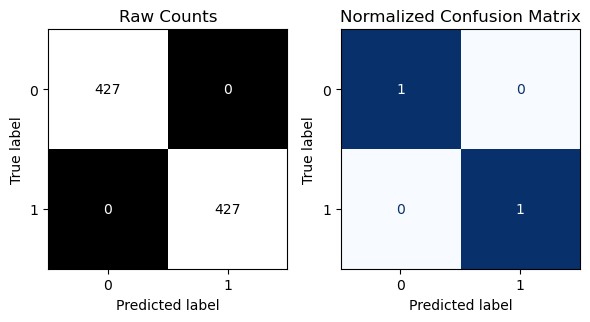


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.75      0.76        52
           1       0.91      0.91      0.91       137

    accuracy                           0.87       189
   macro avg       0.84      0.83      0.83       189
weighted avg       0.87      0.87      0.87       189



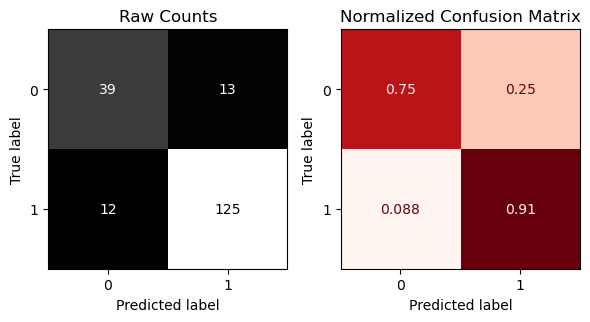

Training time was: 0:00:00.706542


In [12]:
# Model w/o PCA

# Import datetime library
import datetime as dt

# Record the start time
start = dt.datetime.now()

clf = RandomForestClassifier(random_state=42)

clf.fit(X_train_sm, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_baseline = end-start

evaluate_classification(clf, X_train_sm,y_train_sm, X_test_tf, y_test)
print(f'Training time was: {dur_baseline}')

In [13]:
## PCA 

# Instantiate & fit data using PCA
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca = pca.transform(X_test_tf)
X_train_pca.head()

,pca0,pca1,pca2
0,5.587589,1.236287,0.235052
1,-11.412440,4.626752,-18.633769
2,-8.905206,-8.919244,1.909033
3,-0.063693,-3.294742,1.951409
4,1.209280,-6.971001,3.144089


----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



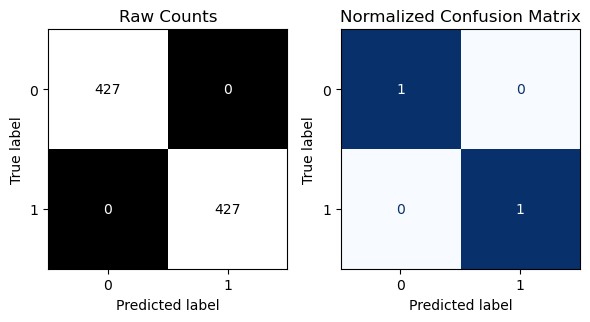


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.69      0.63        52
           1       0.87      0.80      0.84       137

    accuracy                           0.77       189
   macro avg       0.72      0.75      0.73       189
weighted avg       0.79      0.77      0.78       189



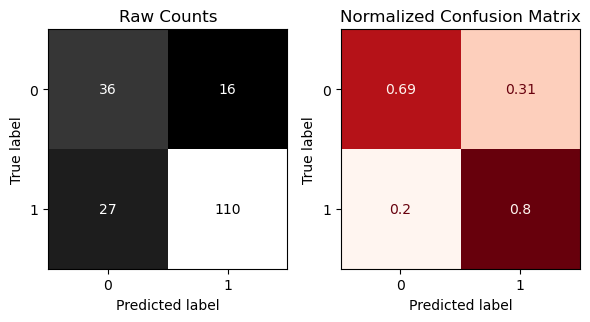

Training time was: 0:00:00.130385


In [14]:
# Time a model with 3 PCs

# Record the start time
start = dt.datetime.now()

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_pca = end-start

evaluate_classification(clf, X_train_pca,y_train_sm, X_test_pca, y_test)
print(f'Training time was: {dur_pca}')

In [15]:
# Compare speeds before and after PCA
compare_speed = dur_baseline/dur_pca
print(f"Using PCs was {compare_speed:.2f} times faster!")

Using PCs was 5.42 times faster!


In [16]:
# Choosing the number of components to return

# Initialize and fit PCA
pca = PCA()
pca.fit(X_train_sm, y_train)

PCA()

In [17]:
# Determine how much variance is explained by each PC
explained = pd.Series(pca.explained_variance_ratio_, name='Explained Variance Ratio')
explained

0      1.550904e-01
1      9.634465e-02
2      8.954398e-02
3      4.594052e-02
4      3.894062e-02
           ...     
748    7.806156e-34
749    7.806156e-34
750    7.806156e-34
751    7.806156e-34
752    3.068598e-34
Name: Explained Variance Ratio, Length: 753, dtype: float64

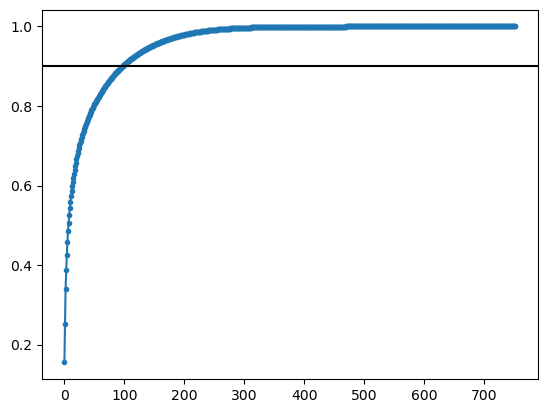

In [18]:
# plot the cumulative sum of the percentage of explained variance for each component and those before it.
ax = explained.cumsum().plot(marker='.')
# add a line to mark .9 (or 90%) variance explained
ax.axhline(.9, color='k');

The code below is an example of how to ensure that enough components are returned to explain 85% of the variance.

In [19]:
# Define PCA to address 85% of the variance
pca85 = PCA(n_components=.85)
# fit and transform on training data
X_train_pca85 = pca85.fit_transform(X_train_sm)
# transform test data
X_test_pca85 = pca85.transform(X_test_tf)
# obtain the number of PCs used
pca85.n_components_

70

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       427
           1       1.00      1.00      1.00       427

    accuracy                           1.00       854
   macro avg       1.00      1.00      1.00       854
weighted avg       1.00      1.00      1.00       854



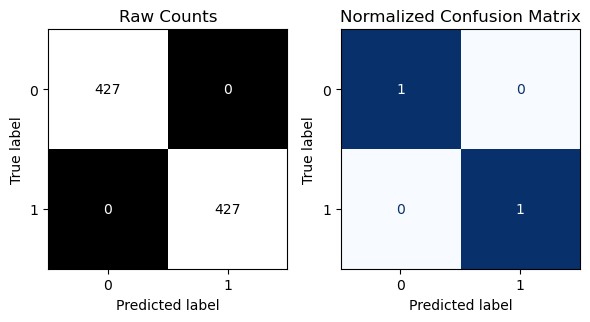


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.72      0.60      0.65        52
           1       0.86      0.91      0.88       137

    accuracy                           0.83       189
   macro avg       0.79      0.75      0.77       189
weighted avg       0.82      0.83      0.82       189



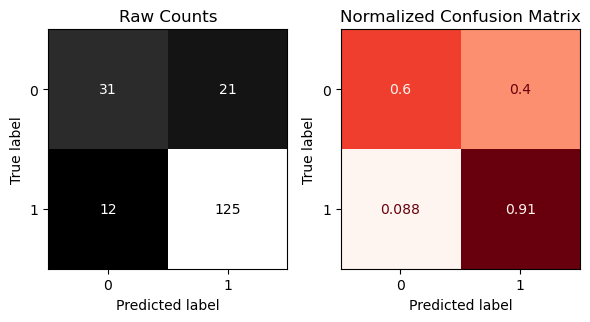

Training time was: 0:00:00.284058


In [20]:
# Timing when we use 85% of the variance

# Record the start time
start = dt.datetime.now()

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca85, y_train_sm)

# Record the end time and calc duration
end = dt.datetime.now()
dur_pca_85 = end-start

evaluate_classification(clf, X_train_pca85,y_train_sm, X_test_pca85, y_test)
print(f'Training time was: {dur_pca_85}')

In [21]:
compare_speed = dur_baseline/dur_pca_85
print(f"Using PC's with .85 was {compare_speed:.2f} times faster!")

Using PC's with .85 was 2.49 times faster!
